# Advanced Lane Lines Detecting Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# First les't import the need dependencies

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
# First step: prepare the 3D object points

objpoints = [] # undistorted real image points (3D points)
imgpoints = [] # 2D image points 
# we need to map the coordinates of the imgpoints to objpoints

# The object points (objpoints) will always be the same which are the known object points of the chessboard corners
# i.e. (0,0,0) for the first corner on the top left, and (8,5,0) for the last corner in the right bottom
# the z-coordinate is zero for all the points

# Now let's prepare the points of the objpoints 

objp = np.zeros((6*9, 3), np.float32)  # this creates a 54 x 3 matrix filled with zeros
#print("objp with zeros", objp)
#print("objp shape", objp.shape)

# now let's fill the x and y with the coordinates we want (i.e. (0,0,0), (1,0,0),....(8,0,0), (0,1,0), (1,1,0),...)  
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#print("filled objp", objp)
#print("objp.shape", objp.shape)

error: no corners found in photo:  camera_cal/calibration1.jpg
error: no corners found in photo:  camera_cal/calibration5.jpg
error: no corners found in photo:  camera_cal/calibration4.jpg


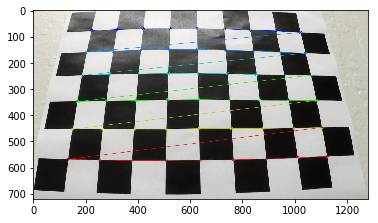

In [4]:
# Second step: get the corners of multiple distorted images
images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    # convert the image to gray to easily deal with it 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.imshow(gray, cmap="gray")

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners) # add the corners to the distorted image points
        objpoints.append(objp)    # the object points are always the same
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
    else:
        print("error: no corners found in photo: ", fname)

In [5]:
# Third step: Determine the camera matrix

# using the objectpoints we got from all the calibration images and the object points we constructed, we now:
# get the following 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## 2. Apply a distortion correction to raw images.

array([[[209, 221, 227],
        [210, 222, 228],
        [210, 222, 228],
        ...,
        [205, 217, 221],
        [206, 218, 222],
        [206, 218, 222]],

       [[209, 221, 227],
        [209, 221, 227],
        [210, 222, 228],
        ...,
        [206, 218, 222],
        [205, 217, 221],
        [205, 217, 221]],

       [[209, 221, 227],
        [209, 221, 227],
        [209, 221, 227],
        ...,
        [206, 218, 222],
        [205, 217, 221],
        [206, 218, 222]],

       ...,

       [[184, 196, 201],
        [183, 195, 201],
        [183, 195, 201],
        ...,
        [177, 189, 191],
        [178, 190, 192],
        [177, 189, 191]],

       [[184, 196, 201],
        [183, 195, 201],
        [182, 194, 200],
        ...,
        [178, 190, 192],
        [179, 191, 193],
        [179, 191, 193]],

       [[184, 196, 202],
        [184, 196, 202],
        [183, 195, 201],
        ...,
        [179, 191, 193],
        [180, 192, 194],
        [178, 190, 192]]

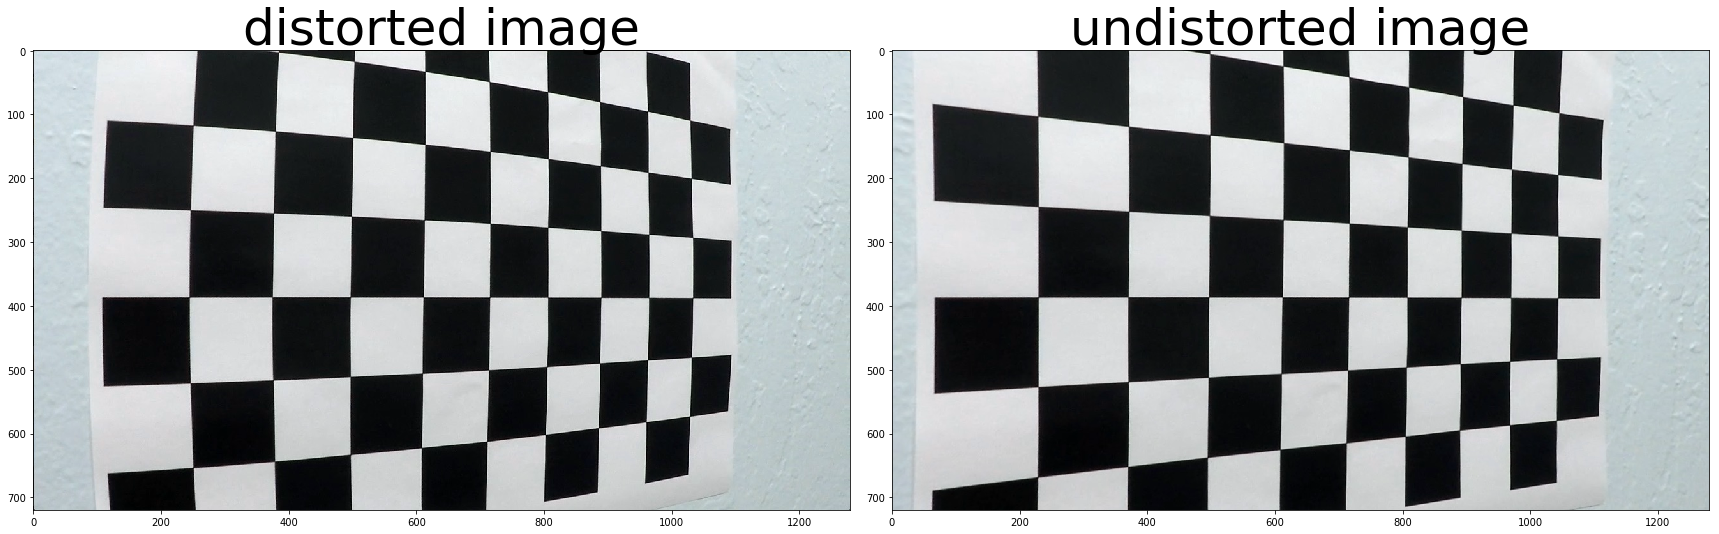

In [6]:
# Undistort the images using the camera matrix¶
# Now let's read a test image and try to undistort it
img = cv2.imread('camera_cal/calibration5.jpg')

def undistort_image(img, mtx, dist):
    # now undistor this image using the parameters determined in the previous steps
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('distorted image', fontsize=50)
    ax2.imshow(undist, cmap='gray')
    ax2.set_title('undistorted image', fontsize=50)
    return undist

undistort_image(img, mtx, dist)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

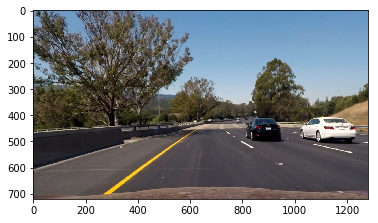

In [7]:
# Read in an image
im = mpimg.imread('test_images/test6.jpg')
# undistort the image
im = cv2.undistort(im, mtx, dist, None, mtx)
plt.imshow(im)

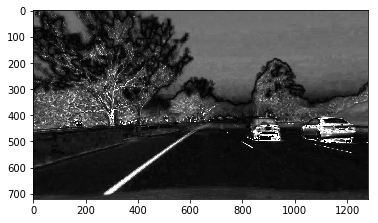

In [8]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel, cmap='gray')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

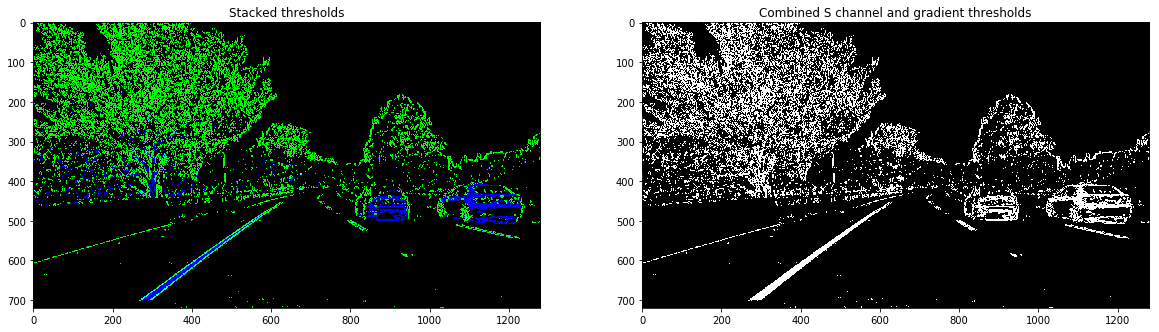

In [9]:
def thresholding(img, grad_to='gray', thresh=(20,100), s_thresh=(170,255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # grad_to = 'gray' # apply gradient to the gray image
    # grad_to = 's'    # apply gradient to the s-channel image
    if grad_to == 'gray':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    elif grad_to == 's':  
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x

    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')   
    return combined_binary

# call the function thresholding()
thresholding(im, grad_to='gray', thresh=(20,100), s_thresh=(170,255))

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [10]:
#def change_prespective()

In [11]:
def change_prespective(img, trap_bottom_width, trap_top_width, trap_height_from_top, tap_bottom_trim, offset):
 
    '''
        1  2

     3         4
    '''
    src = np.float32([[img.shape[1]*(0.5 - trap_top_width/2), img.shape[0]*trap_height_from_top],
                      [img.shape[1]*(0.5 + trap_top_width/2), img.shape[0]*trap_height_from_top], 
                      [img.shape[1]*(0.5 - trap_bottom_width/2), img.shape[0]*tap_bottom_trim],
                      [img.shape[1]*(0.5 + trap_bottom_width/2), img.shape[0]*tap_bottom_trim]])
    dst = np.float32([[offset, 0],
                      [img.shape[1]-offset, 0], 
                      [offset, img.shape[0]], 
                      [img.shape[1]-offset,img.shape[0]]])

    img_size = (img.shape[1], img.shape[0])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
     
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('image', fontsize=50)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('warped image', fontsize=50)
    
    return warped, M

## 5. Detect lane pixels and fit to find the lane boundary.

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


# Test Pipeline on images

All the needed processing steps are defined as functions before and here we will be calling those functions:
- read_image()
- undistort_image()
- thresholding()
- change_prespective()
- fit_polynomial()
- get_curvature()
- wrap_lanes_on_image()
- display_info()

In [21]:
# read_image()
%matplotlib inline
def read_image(im_path):
    img = mpimg.imread(im_path)
    return img

im_path = 'test_images/test1.jpg'
img = read_image(im_path)

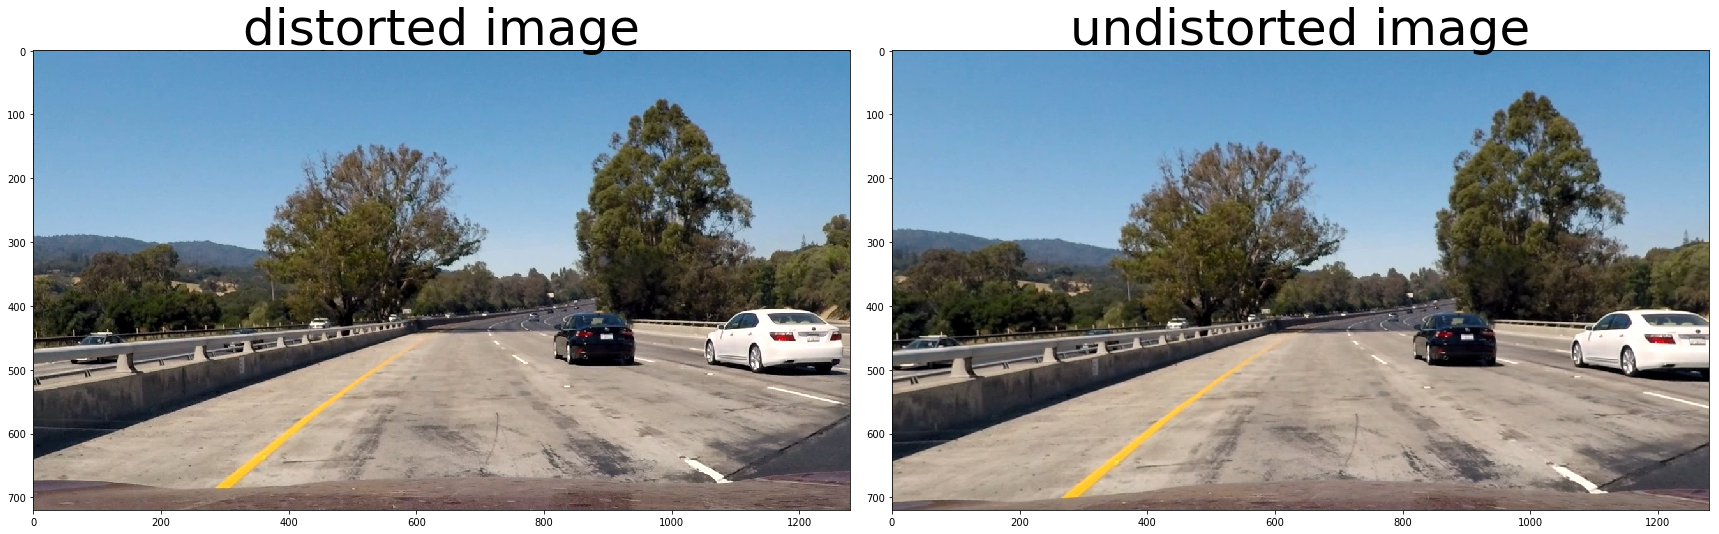

In [22]:
# undistort_image()
undistorted_image = undistort_image(img, mtx, dist)

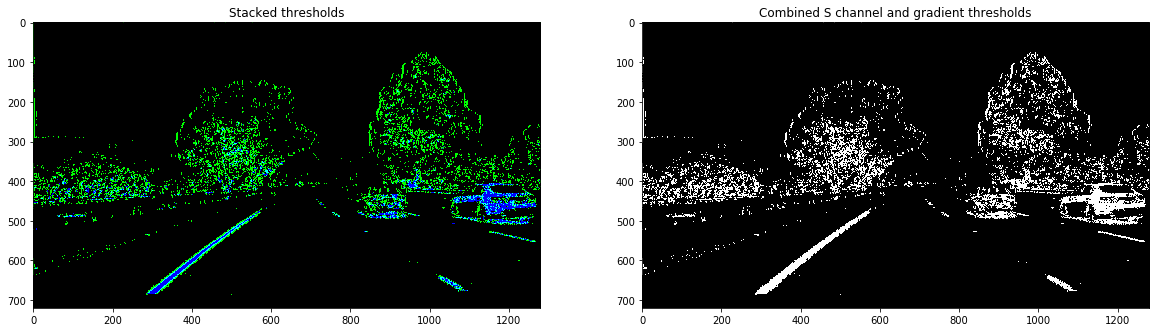

In [23]:
# thresholding()
combined_binary = thresholding(img, grad_to='s', thresh=(20,100), s_thresh=(170,255))

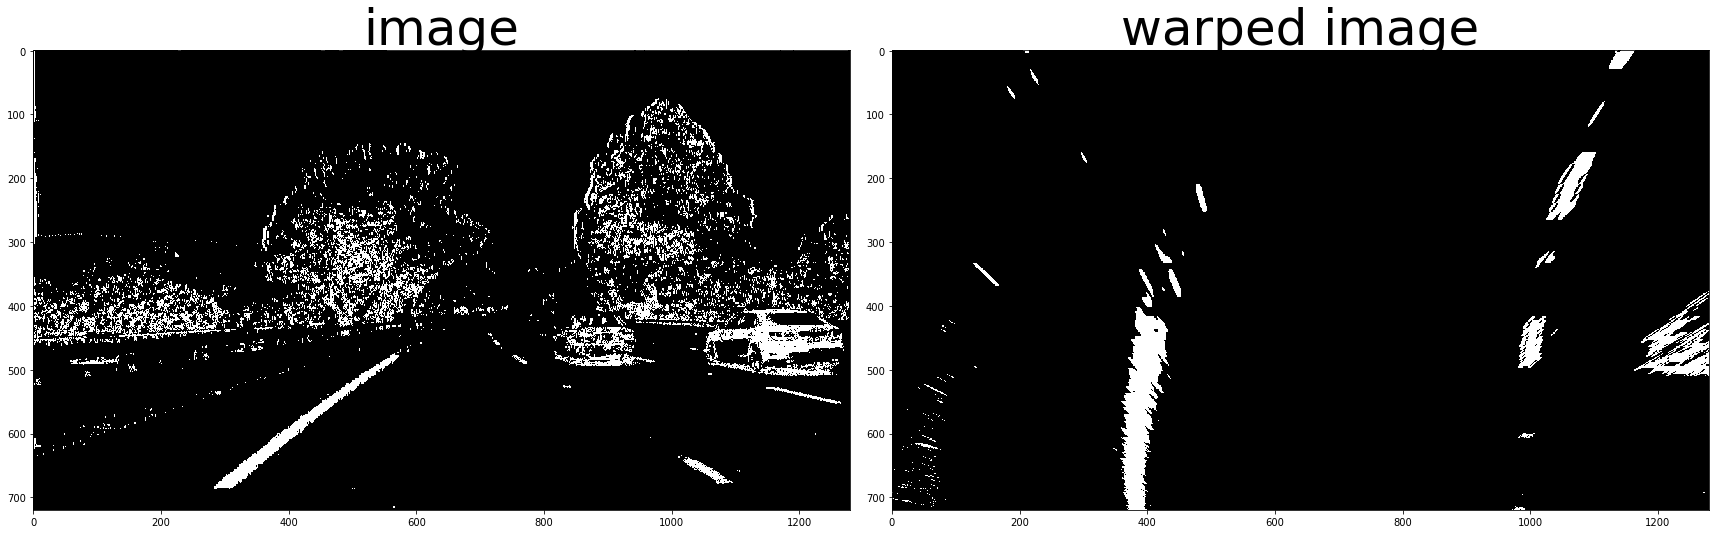

In [24]:
# change_prespective()
# values inspired by the Q & A video from Udacity Youtube channel with some adjustment
trap_bottom_width = 0.7
trap_top_width = 0.09
trap_height_from_top = 0.62 #(450/720 where 450 is end of right line and 720 is total height)
tap_bottom_trim = 0.9
offset = img.shape[1] * 0.2
top_down, perspective_M = change_prespective(combined_binary, 
                                             trap_bottom_width,
                                             trap_top_width,
                                             trap_height_from_top,
                                             tap_bottom_trim,
                                             offset)

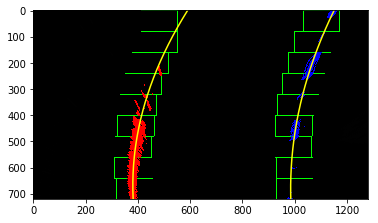

In [25]:
# Calling function fit_polynomial() to find the lane pixels and fit a polynomial
out_img, left_fit, right_fit = fit_polynomial(top_down)
plt.imshow(out_img)

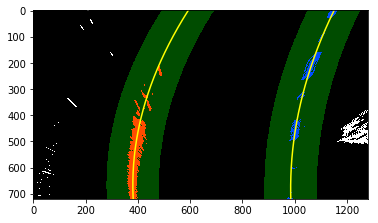

In [26]:
# call function search_around_poly() if a fit is found to avoid searching again with windows
# Do this starting from the second frame of a video if poly fit is found in the first frame
result = search_around_poly(top_down, left_fit, right_fit)

# View your output
plt.imshow(result)